# Analysis

1. Precipitation analysis for the last 12 months starting August 24, 2016 - August 23, 2017. It includes precipitation data for all weather stations in Hawaii.

2. Station analysis for the most active stations in Hawaii including the 12 months of temperature observation data

3. Temperature analysis for 15 days of vacation days, including the min , avg, and max temperatures in Hawaii. 


In [1]:
# Import SQLAlchemy dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine,inspect, func, desc
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session

#Dependencies for analysis
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Create engine & connection
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo = False)
conn = engine.connect()

In [3]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [4]:
# Map measurement and station classes (saving references)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
# create a session
session = Session(engine)

# Precipitation Analysis

In [67]:
# Retrieve the last 12 months of precipitation data
# query to retreieve latest date
lastest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#query to retrieve 365 days from lastest_date
first_date = dt.date(2017,8, 23) - dt.timedelta(days=365)

one_year_precipitation = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > first_date).\
                        order_by(Measurement.date).all()

In [77]:
# Creating dataframe
precipitation_df = pd.DataFrame(one_year_precipitation, columns=['Date', 'Precipitation'])
# precipitation_df.head()

# Change the date to a datetime format.
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format='%Y/%m/%d')

#Get the total for each station for each date and set the index as the date.
total_precipitation = precipitation_df.pivot_table(precipitation_df, index=['Date'], aggfunc='mean')
total_precipitation.head()
# precipitation_df.dtypes

,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


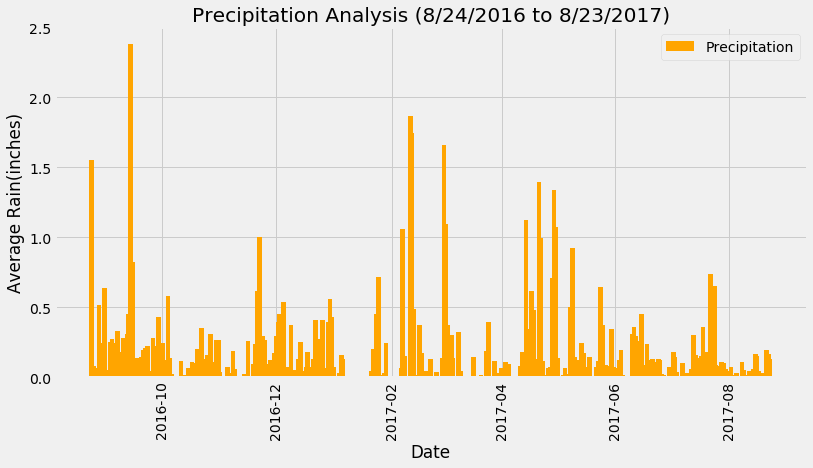

In [78]:
# Plot the dataframe as a horizontal bar chart using pandas plotting
style.use('fivethirtyeight')

plt.bar(total_precipitation.index, total_precipitation["Precipitation"], width=2.5, color="orange")
plt.rcParams["figure.figsize"] = [12,6]
plt.xlabel("Date")
plt.ylabel("Average Rain(inches)")
plt.title("Precipitation Analysis (8/24/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=90)
plt.show()
plt.savefig("Images/Precipitation_Analysis.png")


In [9]:
#Summary Statistics
total_precipitation.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Station Analysis

In [33]:
#Find the total number of stations
total_stations = session.query(Station.station).count()
print("There are a total of:" + " " + str(total_stations) + " " + "stations")

There are a total of: 9 stations


In [11]:
# What are the most active stations?
# List the stations and the counts in descending order.
# Query to find observation counts by station
station_tobs = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.tobs).desc())

# Printing observations
for station in station_tobs:
    print(station)
    
# Storing station name
top_station = station_tobs[0][0]

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [12]:
#Which station has the highest number of observations?
max_observations = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.tobs).desc()).first()
for station in max_observations:
    print(station)

USC00519281
2772


In [13]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
station_12months = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
                    filter(Measurement.station == Station.station).\
                    group_by(Measurement.station).\
                    filter(Measurement.date > first_date).\
                    order_by(func.count(Measurement.tobs).desc()).all()

busiest_station = station_12months[0][0:2]   

print("The stations with the highest number of observations in the last 12 months in descending order are:")
print()
for station, name, count in station_12months:
    print("Station:",station, "in",name,"with",count, "observations.")

The stations with the highest number of observations in the last 12 months in descending order are:

Station: USC00519397 in WAIKIKI 717.2, HI US with 360 observations.
Station: USC00519281 in WAIHEE 837.5, HI US with 351 observations.
Station: USC00516128 in MANOA LYON ARBO 785.2, HI US with 348 observations.
Station: USC00513117 in KANEOHE 838.1, HI US with 342 observations.
Station: USC00519523 in WAIMANALO EXPERIMENTAL FARM, HI US with 336 observations.
Station: USC00514830 in KUALOA RANCH HEADQUARTERS 886.9, HI US with 304 observations.
Station: USC00517948 in PEARL CITY, HI US with 182 observations.


In [22]:
# TOBS = Temperature OBServation 
# Filter by the station with the highest number of observations.
highest_obs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest_station[0]).\
    filter(Measurement.date > first_date).\
    order_by(Measurement.date).all()

#DataFrame. 
highest_obs_df = pd.DataFrame(highest_obs, columns=['Date', 'Tobs'])
tobs_df.head()

,Date,Tobs
0,2016-08-24,79.0
1,2016-08-25,80.0
2,2016-08-26,79.0
3,2016-08-27,77.0
4,2016-08-28,78.0


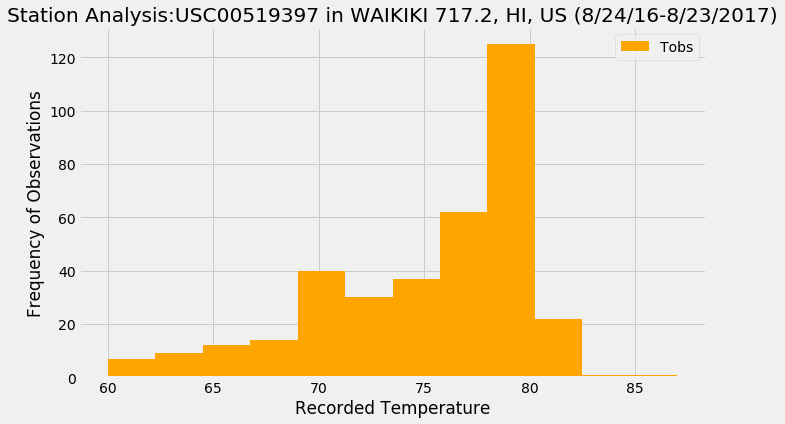

In [24]:
#Histograph
plt.hist(highest_obs_df['Tobs'], bins=12, color = 'orange')
plt.rcParams['figure.figsize'] = [10,6]
plt.xlabel('Recorded Temperature')
plt.ylabel('Frequency of Observations')
plt.title("Station Analysis:USC00519397 in WAIKIKI 717.2, HI, US (8/24/16-8/23/2017)")
plt.legend(['Tobs'])
plt.show()

# Temperature Analysis

In [38]:
#Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using
#the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

# Convering to date time
def calc_temps(start_date, end_date):
    query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.date >= start_date). filter(Measurement.date <= end_date). all()
    
    for Min_temp, Max_temp, Avg_temp in query:
        print("From", start_date, "to", end_date, "the minimum temperature is",Min_temp, '\u00b0'"F, the maximum temperature is",
              Max_temp, '\u00b0'"F.")
# 15 day vacation
calc_temps('2017-08-01', '2017-08-15')

From 2017-08-01 to 2017-08-15 the minimum temperature is 70.0 °F, the maximum temperature is 84.0 °F.


In [54]:
start_date = '2017-08-01'
end_date = '2017-08-15'

vacation_2017 = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

#put it in a dataframe

Vacation_temperatures = pd.DataFrame(vacation_2017, columns=['Date', 'Tobs'])
Vacation_temperatures.head()

,Date,Tobs
0,2017-08-01,77.0
1,2017-08-02,73.0
2,2017-08-03,79.0
3,2017-08-04,80.0
4,2017-08-05,81.0


In [55]:
# obtaining whisker box elements
Vacation_temperatures.describe()

,Tobs
count,61.000000
mean,78.868852
std,3.283674
min,70.000000
25%,77.000000
50%,80.000000
75%,81.000000
max,84.000000


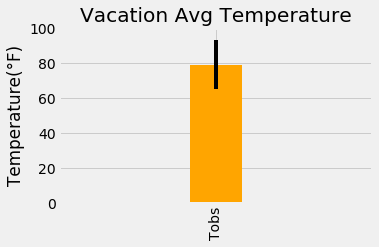

In [56]:
#Whisker Box 
avg_temp = Vacation_temperatures.mean()
temperature_range = (Vacation_temperatures['Tobs'].max() - Vacation_temperatures['Tobs'].min())

p = avg_temp.plot(legend = False, kind = 'bar', color = 'orange', yerr = temperature_range,
                 width = 0.1, figsize = (5,3))
p.set_title("Vacation Avg Temperature")
p.set_ylabel("Temperature(°F)")
p.set_ylim(0,100)
plt.show()